In [1]:
import numpy as np
from astropy.io import fits
from math import ceil, floor
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import glob
from tqdm import tqdm
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.cosmology import FlatLambdaCDM


In [ ]:
# get psi maps from cats folder
Name = "MACS J1149.5+2223"
name = "macs1149"
data_path = f"/home/dices/Research/GWlensing_Brian/GCdata/{Name}/cats/range/"
psi_file_pattern = os.path.join(data_path, f"hlsp_frontier_model_{name}_cats-map???_v4_psi.fits")
file_list_psi = sorted(glob.glob(psi_file_pattern))
N_files_psi = len(file_list_psi)
print(f"Found {N_files_psi} psi FITS files.")

# --- 2. Get dimensions from the first file ---
# You only need to do this once.
first_map = fits.getdata(file_list_psi[0])
H, W = first_map.shape
print(f"Dimensions of the maps: {H} x {W}")


Found 197 psi FITS files.
Dimensions of the maps: 600 x 600


In [23]:
# pixel scale of the maps
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
import astropy.units as u

h = fits.getheader(file_list_psi[0])
w = WCS(h)

# degrees/pixel along each image axis on the WCS projection plane:
deg_per_pix = proj_plane_pixel_scales(w.celestial)

# convert to arcsec/pixel
arcsec_per_pix = (deg_per_pix * u.deg).to(u.arcsec)
print(arcsec_per_pix)         # e.g. [0.396 arcsec/pix, 0.396 arcsec/pix]

[0.5005005 0.5005005] arcsec


In [252]:
# calculate a mean map for psi
# Re-initialize an array to hold all psi maps for mean calculation
print("Loading all psi maps for mean calculation...")
all_psi_maps = np.empty((N_files_psi, H, W), dtype=np.float64)
for i, filename in enumerate(file_list_psi):
    data = fits.getdata(filename).astype(np.float64)
    if data.shape != (H, W):
        raise ValueError(f"File {filename} has shape {data.shape}, expected ({H}, {W})")
    all_psi_maps[i] = data
print("All psi maps loaded.")
# Compute the mean across the first axis (N_files)
psi_mean = np.mean(all_psi_maps, axis=0)
print("Mean calculation finished.")
# Clean up memory
del all_psi_maps
print("Memory cleaned up.")

Loading all psi maps for mean calculation...
All psi maps loaded.
Mean calculation finished.
Memory cleaned up.


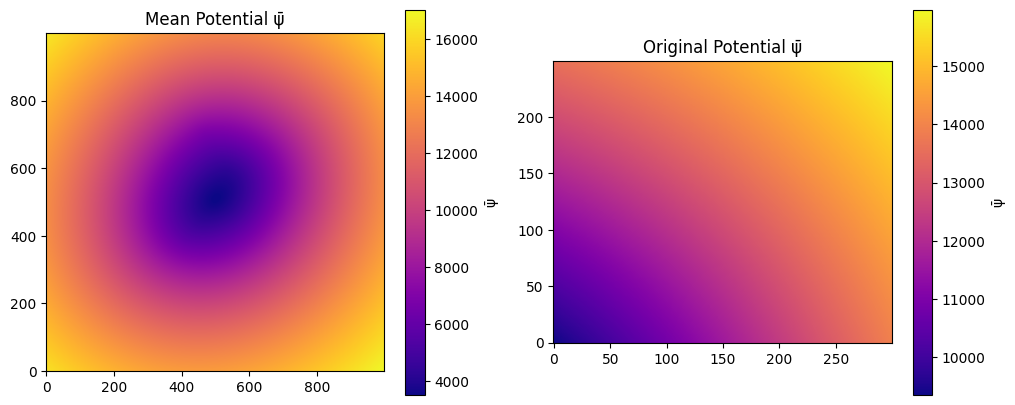

In [253]:
# --- 5. Visualization and comparing with the original map---
# mean map
fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].imshow(psi_mean, origin='lower', cmap='plasma')
ax[0].set_title("Mean Potential ψ̄")
fig.colorbar(ax[0].imshow(psi_mean, origin='lower', cmap='plasma'), ax=ax[0], label="ψ̄")

# original map
psi_file = f'/home/dices/Research/GWlensing_Brian/GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_psi.fits'
ax[1].imshow(fits.getdata(psi_file), origin='lower', cmap='plasma')
ax[1].set_title("Original Potential ψ̄")
fig.colorbar(ax[1].imshow(fits.getdata(psi_file), origin='lower', cmap='plasma'), ax=ax[1], label="ψ̄")

In [254]:
# save the mean map to a fits file with the same header as the original file
original_psi_file = f'/home/dices/Research/GWlensing_Brian/GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_psi.fits'
with fits.open(original_psi_file) as hdul:
    header = hdul[0].header
    hdu = fits.PrimaryHDU(data=psi_mean, header=header)
    output_filename = original_psi_file
    hdu.writeto(output_filename, overwrite=True)
    print(f"Mean psi map saved to {output_filename}")


Mean psi map saved to /home/dices/Research/GWlensing_Brian/GCdata/MACS J1149.5+2223/cats copy/hlsp_frontier_model_macs1149_cats_v4_psi.fits


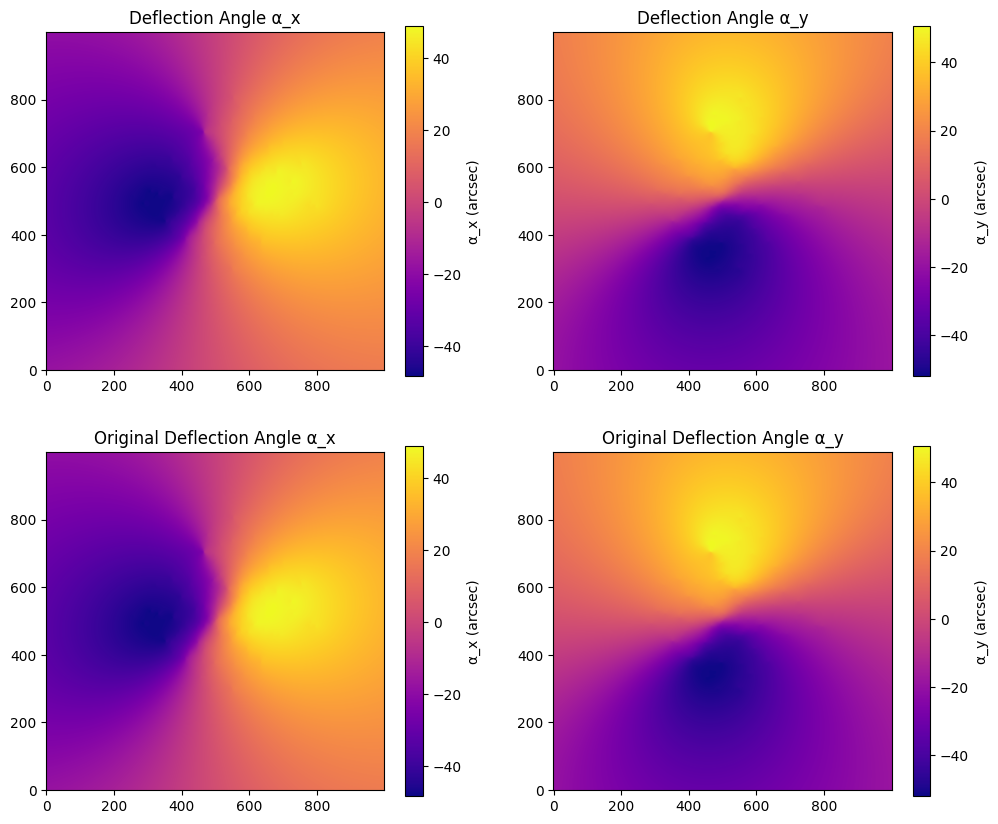

In [255]:
# get the alpha maps from the mean psi map by differentiation

dx = 0.5
dy = 0.5 # in arcsec/pixel

# Compute gradients
alpha_y, alpha_x = np.gradient(psi_mean, dy, dx)

# Visualize the alpha maps and compare with original maps
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
im1 = ax[0, 0].imshow(alpha_x, origin='lower', cmap='plasma')
ax[0, 0].set_title("Deflection Angle α_x")
fig.colorbar(im1, ax=ax[0, 0], label="α_x (arcsec)")
im2 = ax[0, 1].imshow(alpha_y, origin='lower', cmap='plasma')
ax[0, 1].set_title("Deflection Angle α_y")
fig.colorbar(im2, ax=ax[0, 1], label="α_y (arcsec)")

# original alpha maps
alpha_x_original = f'/home/dices/Research/GWlensing_Brian/GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_x-arcsec-deflect.fits'
alpha_y_original = f'/home/dices/Research/GWlensing_Brian/GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_y-arcsec-deflect.fits'
im3 = ax[1, 0].imshow(fits.getdata(alpha_x_original), origin='lower', cmap='plasma')
ax[1, 0].set_title("Original Deflection Angle α_x")
fig.colorbar(im3, ax=ax[1, 0], label="α_x (arcsec)")
im4 = ax[1, 1].imshow(fits.getdata(alpha_y_original), origin='lower', cmap='plasma')
ax[1, 1].set_title("Original Deflection Angle α_y")
fig.colorbar(im4, ax=ax[1, 1], label="α_y (arcsec)")
plt.show()



In [256]:
# save the modified alpha maps to fits files
with fits.open(alpha_x_original) as hdul:
    header = hdul[0].header
    hdu = fits.PrimaryHDU(data=alpha_x, header=header)
    output_filename = alpha_x_original
    hdu.writeto(output_filename, overwrite=True)
    print(f"Modified alpha_x map saved to {output_filename}")
with fits.open(alpha_y_original) as hdul:
    header = hdul[0].header
    hdu = fits.PrimaryHDU(data=alpha_y, header=header)
    output_filename = alpha_y_original
    hdu.writeto(output_filename, overwrite=True)
    print(f"Modified alpha_y map saved to {output_filename}")

Modified alpha_x map saved to /home/dices/Research/GWlensing_Brian/GCdata/MACS J1149.5+2223/cats copy/hlsp_frontier_model_macs1149_cats_v4_x-arcsec-deflect.fits
Modified alpha_y map saved to /home/dices/Research/GWlensing_Brian/GCdata/MACS J1149.5+2223/cats copy/hlsp_frontier_model_macs1149_cats_v4_y-arcsec-deflect.fits


Cluster: MACS J1149.5+2223
scal: 0.7014352098139855
600


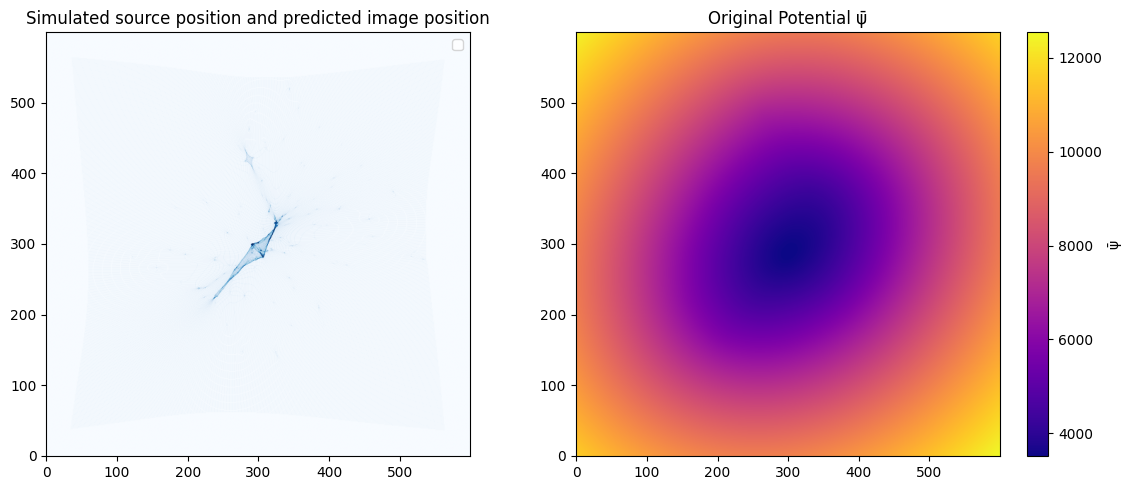

In [2]:
# plotting the origianal lens map to prepare for cutting
# load all the lens maps
scenarios = {
    '1': 'abell370',
    '2': 'abell2744',
    '3': 'abells1063',
    '4': 'macs0416',
    '5': 'macs0717',
    '6': 'macs1149'
}

full_cluster_names = {
    'abell370': 'Abell 370',
    'abell2744': 'Abell 2744',
    'abells1063': 'Abell S1063',
    'macs0416': 'MACS J0416.1-2403',
    'macs0717': 'MACS J0717.5+3745',
    'macs1149': 'MACS J1149.5+2223'
}

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_psi.fits'
    )

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi:
        datax = hdulx[0].data
        datay = hduly[0].data
        data_psi = hdul_psi[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)


# look at the lens map of cluster with index i

index = 5
Name = full_cluster_names[scenarios[str(index+1)]]
name = scenarios[str(index+1)]
print(f"Cluster: {Name}")

cosmology = FlatLambdaCDM(H0=70, Om0=0.3)
z_l = 0.543
z_s = 3.493726569972465
D_LS = cosmology.angular_diameter_distance_z1z2(z_l, z_s)
D_S = cosmology.angular_diameter_distance(z_s)

# Scale deflection map
scal = D_LS / D_S
print(f"scal: {scal}")
size = len(datax_list[index])
print(size)
array_test = np.zeros((size,size))
pixscale = 0.5
datay = datay_list[index]/pixscale
datax = datax_list[index]/pixscale
# scal factor for real deflection map
datay *= scal
datax *= scal
for i in range(0,size):
    for j in range(0,size):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        ydec = ycoord%1
        xdec = xcoord%1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor,xfloor] += 1

fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].imshow(array_test, cmap='Blues', vmax = 50, origin = 'lower')
# ax[0].set_xlim(200,800)
# ax[0].set_ylim(200,800)
# ax[0].scatter(500,520, c = 'orange', marker='d', s=50)

ax[0].set_title('Simulated source position and predicted image position')
ax[0].legend(['Source position','Image position'])

ax[1].imshow(data_psi_list[index], origin = 'lower', cmap='plasma')
ax[1].set_title('Original Potential ψ̄')
fig.colorbar(ax[1].imshow(data_psi_list[index], origin = 'lower', cmap='plasma'), ax=ax[1], label="ψ̄")
plt.tight_layout()

Successfully created a (600, 600) cutout and saved to /home/dices/Research/GWlensing_Brian/GCdata/MACS J1149.5+2223/cats copy/hlsp_frontier_model_macs1149_cats_v4_psi.fits


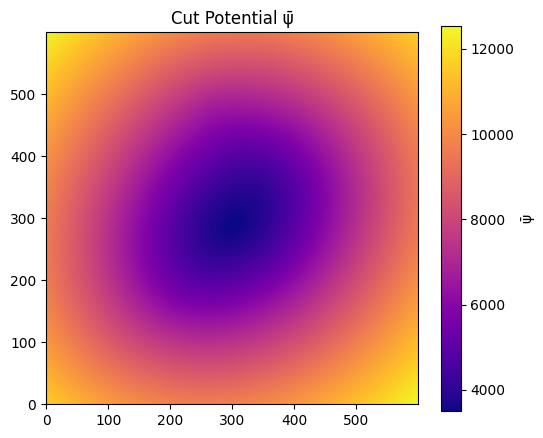

In [261]:
# cut the cluster map to a smaller size for faster computation

# Path to your input and output FITS files
input_fits_file = os.path.join(
        file_dir,
        f'GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_psi.fits'
    )
output_fits_file = input_fits_file

# set the center of the cutout
center_x = 500
center_y = 520
position = (center_x, center_y)
size = (600,600)  # pixels (ny, nx)

# Open the original FITS file
with fits.open(input_fits_file) as hdul:
    # Assuming the image data is in the primary HDU (index 0)
    hdu = hdul[0]
    wcs = WCS(hdu.header)
    data = hdu.data

    # Define the center of the original image
    # The center of a 3000x3000 array is at pixel (1499.5, 1499.5)
    # In FITS and WCS, pixel coordinates are often 1-based, so the center is (1500, 1500)
    # The Cutout2D function uses 0-based indexing for the array, so the center is (1499.5, 1499.5)
    # which corresponds to the corner of 4 pixels. We can simply use the integer pixel
    # indices. For a 3000x3000 array, the central indices are 1500, 1500.


    # Create the cutout
    # The wcs is passed to the function to update it for the cutout
    cutout = Cutout2D(data, position, size, wcs=wcs)

    # Update the FITS header with the new WCS
    hdu.header.update(cutout.wcs.to_header())

    # Update the image data with the cutout data
    hdu.data = cutout.data

    # Write the cutout to a new FITS file
    hdu.writeto(output_fits_file, overwrite=True)

print(f"Successfully created a {size} cutout and saved to {output_fits_file}")

# plotting the cut lens map to check
# load the cut lens maps
cut_psi_file = output_fits_file
cut_data = fits.getdata(cut_psi_file)
fig, ax = plt.subplots(1,1, figsize=(6, 5))
im = ax.imshow(cut_data, origin = 'lower', cmap='plasma')
fig.colorbar(im, ax=ax, label="ψ̄")
ax.set_title("Cut Potential ψ̄")
plt.show()

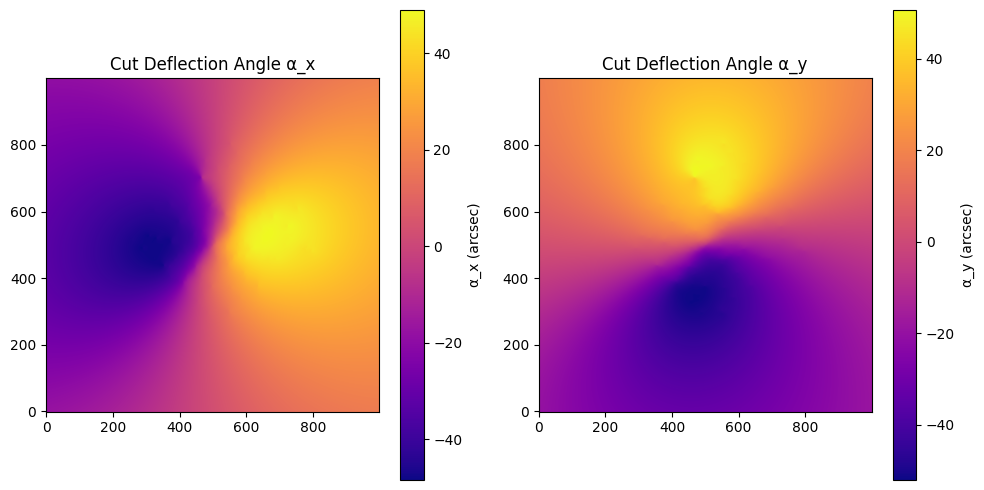

In [262]:
# load the original alpha maps
cut_alpha_x_file = os.path.join(
        file_dir,
        f'GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_x-arcsec-deflect.fits'
    )
cut_alpha_y_file = os.path.join(
        file_dir,
        f'GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_y-arcsec-deflect.fits'
    )
cut_datax = fits.getdata(cut_alpha_x_file)
cut_datay = fits.getdata(cut_alpha_y_file)
fig, ax = plt.subplots(1,2, figsize=(10, 5))
im1 = ax[0].imshow(cut_datax, origin = 'lower', cmap='plasma')
fig.colorbar(im1, ax=ax[0], label="α_x (arcsec)")
ax[0].set_title("Cut Deflection Angle α_x")
im2 = ax[1].imshow(cut_datay, origin = 'lower', cmap='plasma')
fig.colorbar(im2, ax=ax[1], label="α_y (arcsec)")
ax[1].set_title("Cut Deflection Angle α_y")
plt.tight_layout()
plt.show()

In [263]:
# do the same thing for the x and y alpha maps
# Path to your input and output FITS files
input_fits_file_x = os.path.join(
        file_dir,
        f'GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_x-arcsec-deflect.fits'
    )
output_fits_file_x = input_fits_file_x
input_fits_file_y = os.path.join(
        file_dir,
        f'GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_y-arcsec-deflect.fits'
    )
output_fits_file_y = input_fits_file_y
# Open the original FITS file
with fits.open(input_fits_file_x) as hdul:
    # Assuming the image data is in the primary HDU (index 0)
    hdu = hdul[0]
    wcs = WCS(hdu.header)
    data = hdu.data


    # Create the cutout
    # The wcs is passed to the function to update it for the cutout
    cutout = Cutout2D(data, position, size, wcs=wcs)

    # Update the FITS header with the new WCS
    hdu.header.update(cutout.wcs.to_header())

    # Update the image data with the cutout data
    hdu.data = cutout.data

    # Write the cutout to a new FITS file
    hdu.writeto(output_fits_file_x, overwrite=True)
print(f"Successfully created a {size} cutout of x deflection map and saved to {output_fits_file_x}")


with fits.open(input_fits_file_y) as hdul:
    # Assuming the image data is in the primary HDU (index 0)
    hdu = hdul[0]
    wcs = WCS(hdu.header)
    data = hdu.data

    # Create the cutout
    # The wcs is passed to the function to update it for the cutout
    cutout = Cutout2D(data, position, size, wcs=wcs)

    # Update the FITS header with the new WCS
    hdu.header.update(cutout.wcs.to_header())

    # Update the image data with the cutout data
    hdu.data = cutout.data

    # Write the cutout to a new FITS file
    hdu.writeto(output_fits_file_y, overwrite=True)
print(f"Successfully created a {size} cutout of y deflection map and saved to {output_fits_file_y}")


Successfully created a (600, 600) cutout of x deflection map and saved to /home/dices/Research/GWlensing_Brian/GCdata/MACS J1149.5+2223/cats copy/hlsp_frontier_model_macs1149_cats_v4_x-arcsec-deflect.fits
Successfully created a (600, 600) cutout of y deflection map and saved to /home/dices/Research/GWlensing_Brian/GCdata/MACS J1149.5+2223/cats copy/hlsp_frontier_model_macs1149_cats_v4_y-arcsec-deflect.fits


scal: 0.7014352098139855
600


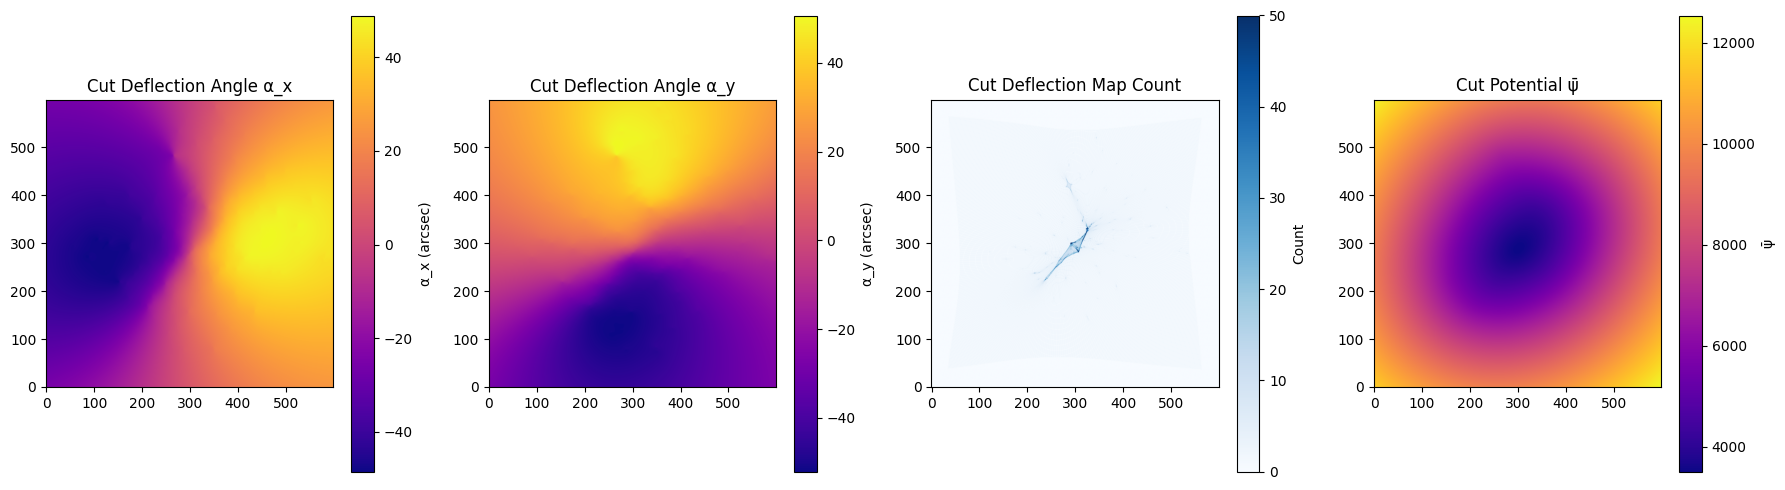

In [264]:
# plotting the cut alpha maps to check
# load the cut lens maps
cut_alpha_x_file = os.path.join(
        file_dir,
        f'GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_x-arcsec-deflect.fits'
    )
cut_alpha_y_file = os.path.join(
        file_dir,
        f'GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_y-arcsec-deflect.fits'
    )
cut_psi_file = os.path.join(
        file_dir,
        f'GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_psi.fits'
    )
cut_datax = fits.getdata(cut_alpha_x_file)
cut_datay = fits.getdata(cut_alpha_y_file)
cut_data_psi = fits.getdata(cut_psi_file)

# the lens map
print(f"scal: {scal}")
size_test = len(cut_datax)
print(size_test)
array_test = np.zeros((size_test,size_test))
datay = cut_datay/pixscale
datax = cut_datax/pixscale
# scal factor for real deflection map
datay *= scal
datax *= scal
for i in range(0,size_test):
    for j in range(0,size_test):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        ydec = ycoord%1
        xdec = xcoord%1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor,xfloor] += 1

fig, ax = plt.subplots(1,4, figsize=(18, 5))
im1 = ax[0].imshow(cut_datax, origin = 'lower', cmap='plasma')
fig.colorbar(im1, ax=ax[0], label="α_x (arcsec)")
ax[0].set_title("Cut Deflection Angle α_x")
im2 = ax[1].imshow(cut_datay, origin = 'lower', cmap='plasma')
fig.colorbar(im2, ax=ax[1], label="α_y (arcsec)")
ax[1].set_title("Cut Deflection Angle α_y")
im3 = ax[2].imshow(array_test, cmap='Blues', vmax = 50, origin = 'lower')
fig.colorbar(im3, ax=ax[2], label="Count")
ax[2].set_title("Cut Deflection Map Count")
im4 = ax[3].imshow(cut_data_psi, origin = 'lower', cmap='plasma')
fig.colorbar(im4, ax=ax[3], label="ψ̄")
ax[3].set_title("Cut Potential ψ̄")

plt.tight_layout()
plt.show()

In [265]:
# do the same thing for the ensemble of psi maps
import glob
data_path = f"/home/dices/Research/GWlensing_Brian/GCdata/{Name}/cats copy/range/"
psi_file_pattern = os.path.join(data_path, f"hlsp_frontier_model_{name}_cats-map???_v4_psi.fits")
file_list_psi = sorted(glob.glob(psi_file_pattern))
N_files_psi = len(file_list_psi)
print(f"Number of psi files found: {N_files_psi}")

for file in tqdm(file_list_psi):
    output_fits_file = file  # Overwrite the same file

    # Open the original FITS file
    with fits.open(file) as hdul:
        # Assuming the image data is in the primary HDU (index 0)
        hdu = hdul[0]
        wcs = WCS(hdu.header)
        data = hdu.data

        # Create the cutout
        cutout = Cutout2D(data, position, size, wcs=wcs)

        # Update the FITS header with the new WCS
        hdu.header.update(cutout.wcs.to_header())

        # Update the image data with the cutout data
        hdu.data = cutout.data

        # Write the cutout to a new FITS file
        hdu.writeto(output_fits_file, overwrite=True)

print(f"Successfully created {size} cutouts for all psi maps in {data_path}")

Number of psi files found: 197


100%|██████████| 197/197 [00:02<00:00, 81.70it/s]

Successfully created (600, 600) cutouts for all psi maps in /home/dices/Research/GWlensing_Brian/GCdata/MACS J1149.5+2223/cats copy/range/


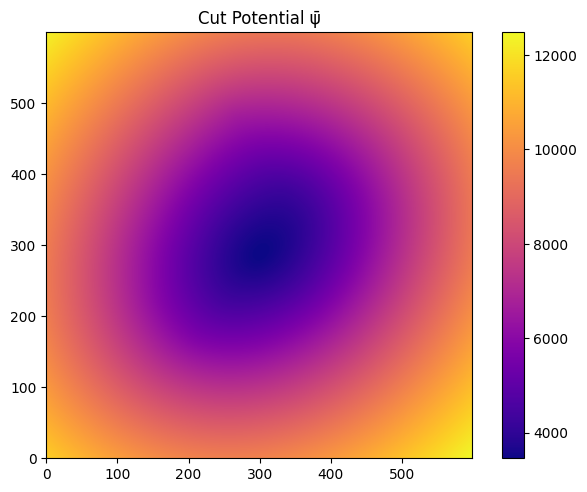

In [269]:
# plotting the ensemble cut lens map to check
psi_file_test = f'/home/dices/Research/GWlensing_Brian/GCdata/{Name}/cats copy/range/hlsp_frontier_model_{name}_cats-map110_v4_psi.fits'

with fits.open(psi_file_test) as hdul_psi:
    data_psi = hdul_psi[0].data


# plot the psi map of the cutout for checking
plt.imshow(data_psi, cmap='plasma', origin = 'lower')
plt.colorbar()
plt.tight_layout()
plt.title("Cut Potential ψ̄")
plt.show()